In [109]:
%matplotlib widget

from sympy import *
import schemdraw
import schemdraw.elements as elm
from IPython.display import Markdown
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import numpy as np
from joblib import Parallel, delayed
from mac_notifications import client

# Tesla Coil
In this notebook we simulate the transfer function characteristics of a Tesla coil given its geometrical definition. This notebook is the result of several scripts merged into a single simulator.

## Parameters
In this section we define all the numerical parameters required for the simulation to run.

### Coil Geometry

In [85]:
# Primary coil radii
rp_i    = 0.12      # [m]
rp_f    = 0.12      # [m]
# Primary coil height
zp_i    = 0         # [m]
zp_f    = 0.05      # [m]
# Primary coil turns
Np      = 10        # [1]
# Primary coil wire characteristics
rp_w    = 2e-3      # [m]
rho_wp  = 1.77e-8   # [Ohm m] 

# Secondary coil radius
rs      = 0.1       # [m]
# Secondary coil height
zs_i    = 0.0       # [m]
zs_f    = 0.55      # [m] (this is also the height of the top-load)
# Secondary coil wire characteristics
rs_w    = 0.2e-3    # [m]
rho_ws  = 1.77e-8   # [Ohm m]

# Torus (top-load) dimensions
R_tl    = 0.12      # [m]
r_tl    = 0.07      # [m]

### Solver Parameters

In [86]:
# ----------------------> INDUCTANCE SOLVER <--------------------- # 
# Angle discretization discretization (magnetic solver)
d_theta = 0.1       # [rad] Angle between points

# Parallelization
cores   = 8         # [1]

# ----------------------> CAPACITANCE SOLVER <-------------------- # 
# Mesh Limits - x
x_min  = -0.5       # [m]
x_max  = +0.5       # [m]
# Mesh Limits - y
y_min  = -0.5       # [m]
y_max  = +0.5       # [m]
# Mesh Limits - z
z_min  = 0          # [m]
z_max  = +1         # [m]

# Discretization step
h_step = 0.01       # [m]
cores  = 8          # [1] number of cores used for computations 

# Maximum error for Jacobi
max_e  = 0.0005     # [V]

### Primary Coil Discretization
We first define a spiral in polar coordinates as
\begin{align}
    r(\theta) &=  (r_f - r_i) \frac{\theta}{2\pi N} + r_i, \\
    z(\theta) &= (z_f - z_i) \frac{\theta}{2\pi N} + z_i  \ , \quad 0 \le \theta \le 2\pi N.
\end{align}
We then transform the euqations in cartesian coordinates
\begin{align}
    x(\theta) &= r(\theta)\cos\theta = \left[(r_f - r_i) \frac{\theta}{2\pi N} + r_i\right]\cos\theta, \\
    y(\theta) &= r(\theta)\sin\theta = \left[(r_f - r_i) \frac{\theta}{2\pi N} + r_i\right]\sin\theta, \\
    z(\theta) &= (z_f - z_i) \frac{\theta}{2\pi N} + z_i.
\end{align}
Therefore we can discretize both $x$ and $y$ to get
\begin{align}
    x[i] &= \left[(r_f - r_i) \frac{i\Delta\theta}{2\pi N} + r_i\right]\cos(i\Delta\theta), \\
    y[i] &= \left[(r_f - r_i) \frac{i\Delta\theta}{2\pi N} + r_i\right]\sin(i\Delta\theta), \\
    z[i] &= (z_f - z_i) \frac{i\Delta\theta}{2\pi N} + z_i.
\end{align}
with $i = 0, 1, \dots, \frac{2\pi N}{\Delta\theta}$.

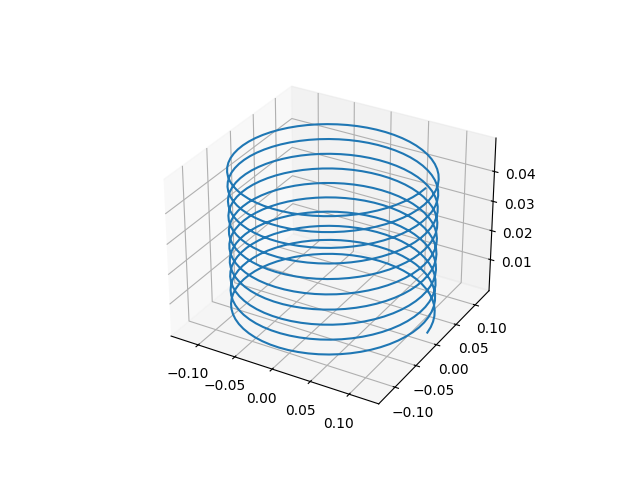

In [87]:
i = np.arange(1, 2*np.pi*Np/d_theta, 1)
xp = ((rp_f - rp_i) * i * d_theta / (2 * np.pi * Np) + rp_i) * np.cos(d_theta * i)
yp = ((rp_f - rp_i) * i * d_theta / (2 * np.pi * Np) + rp_i) * np.sin(d_theta * i)
zp = (zp_f - zp_i) * i * d_theta / (2 * np.pi * Np) + zp_i

ax = plt.figure().add_subplot(projection='3d')
plt.plot(xp, yp, zp)

### Sceondary Coil Discretization
The secondary coil is comprised of a series of circular coils stacked on top of eachother. To reduce computational complexity we opt to group the entire coil in "bunches", achieving an effective number of windings $N_s^\prime = \frac{N_s}{g}$, where $g$ is the grouping factor. 

Therefore each bunched coil is located at $z = \left\{j\frac{(z_f - z_i)}{N_s^\prime} + z_i \ \big| \ j = 0, 1, \dots, N_s^\prime - 1\right\}$ and having $x,y$ coordinates given by the usual expression
\begin{align}
    x(\theta) &= r_s \cos(\theta), \\
    y(\theta) &= r_s \sin(\theta) \ , \quad 0 \le \theta \le 2\pi.
\end{align}
The expression above is readily discretized as
\begin{align}
    x[i] &= r_s \cos(i\Delta\theta), \\
    y[i] &= r_s \sin(i\Delta\theta),
\end{align}
with $i = 0, 1, \dots, \frac{2\pi}{\Delta\theta}$.

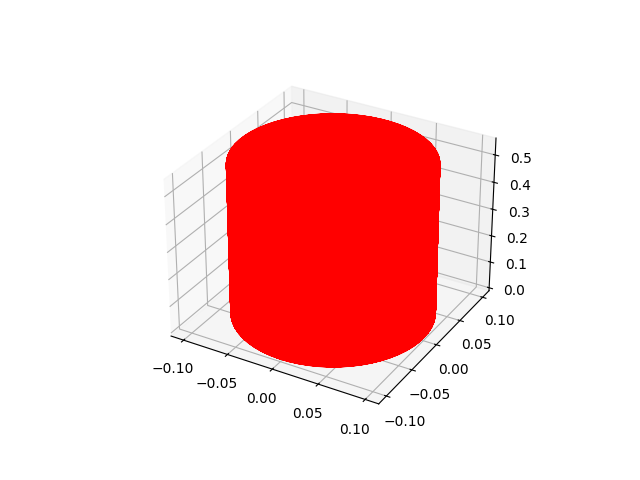

In [88]:
i = np.arange(1, 2*np.pi/d_theta, 1)

x_set = rs * np.cos(i * d_theta)
y_set = rs * np.sin(i * d_theta)
z_set = np.arange(0, Ns, 1) * (zs_f - zs_i)/Ns + zs_i

dim = x_set.size
xs = np.zeros(Ns * dim)
ys = np.zeros(Ns * dim)
zs = np.zeros(Ns * dim)

for index, z_coil in enumerate(z_set):
    for i in range(index*dim, (index + 1)*dim):
        xs[i] = x_set[i - index*dim]
        ys[i] = y_set[i - index*dim]
        zs[i] = z_coil
        
ax = plt.figure().add_subplot(projection='3d')
plt.plot(xs, ys, zs, color='red')

### Torus Definition

The equation of a solid torus in cartesian coordinates is given by
$$
\left(R - \sqrt{x^2 + y^2}\right)^2 + (z - z_0)^2 \le r^2.
$$

In [89]:
x_set = np.arange(x_min, x_max, h_step)
y_set = np.arange(y_min, y_max, h_step)
z_set = np.arange(z_min, z_max, h_step)

L = x_set.size
M = y_set.size
N = z_set.size

is_fixed = np.zeros([L, M, N])
U = np.zeros([L, M, N])

k_load = np.argmin(np.abs(zs_f - z_set))

for i in range(L):
    for j in range(M):
        for k in range(N):
            if (R_tl - np.sqrt(x_set[i]**2 + y_set[j]**2))**2 + (z_set[k]-zs_f)**2 <= r_tl**2:
                is_fixed[i][j][k] = 1
                U[i][j][k] = 1
                continue
            if k == k_load and x_set[i]**2 + y_set[j]**2 < R_tl**2:
                is_fixed[i][j][k] = 1
                U[i][j][k] = 1
                continue

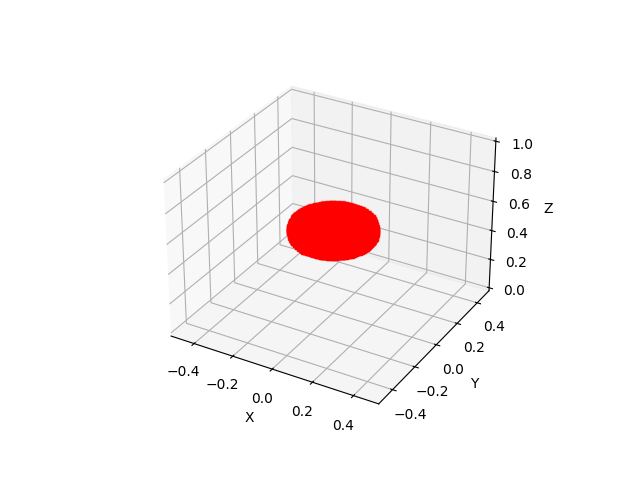

In [90]:
# Get the indices where is_fixed is equal to 1
indices = np.argwhere(is_fixed == 1)

# Plot the points
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_set[indices[:, 0]], y_set[indices[:, 1]], z_set[indices[:, 2]], c='r', marker=',')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Set plot limits
ax.set_xlim([x_min, x_max])
ax.set_ylim([y_min, y_max])
ax.set_zlim([z_min, z_max])

plt.show()

### Resulting Geometry

(0.0, 1.0)

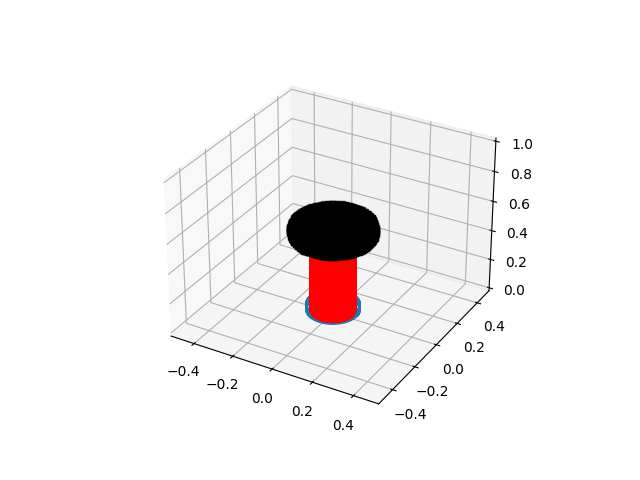

In [91]:
ax = plt.figure().add_subplot(projection='3d')
plt.plot(xp, yp, zp)
plt.plot(xs, ys, zs, color='red')

indices = np.argwhere(is_fixed == 1)
ax.scatter(x_set[indices[:, 0]], y_set[indices[:, 1]], z_set[indices[:, 2]], c='k', marker=',')

# Set plot limits
ax.set_xlim([x_min, x_max])
ax.set_ylim([y_min, y_max])
ax.set_zlim([z_min, z_max])

## Windings Characteristics
In this section we calculate the total resistanze of a coil given $\gamma$ given it's wire radius $r_w$ as
$$
R = \frac{\rho}{\pi r_w^2} \int_\gamma |\mathrm{d}\vec{l}|.
$$
At the same time, we calculate the niumber of turns in the secondary coil given by
$$
N_s = \left\lfloor\frac{z_f - z_i}{2r_w}\right\rfloor
$$

In [92]:
def coil_resistance(rho, rw, gamma_x, gamma_y, gamma_z):
    dim = gamma_x.size
    length = 0
    
    for i in range(dim - 1):
        gamma_i = np.array([gamma_x[i], gamma_y[i], gamma_z[i]])
        gamma_f = np.array([gamma_x[i+1], gamma_y[i+1], gamma_z[i+1]])
        delta = gamma_f - gamma_i
        length = length + np.linalg.norm(delta)
        
    return rho / (np.pi * rw**2) * length

In [93]:
Rp_num = coil_resistance(rho_wp, rp_w, xp, yp, zp)
Rp_num

0.010593531813653106

In [94]:
Rs_num = coil_resistance(rho_ws, rs_w, xs, ys, zs)
Rs_num

110.57410223148523

In [95]:
Ns = int(np.floor((zs_f - zs_i)/(2*rs_w)))
Ns

1375

## Neumann Calculator
This script calculates the self and mutual indictances of a Tesla coil's primary and secondary windings. This is done by applying Neumann formula for the mutual inductance $M_{m,n}$ given two coil geometries $\gamma_m$ and $\gamma_n$
$$
M_{m,n} = \frac{\mu_0}{4\pi}\oint_{\gamma_m}\oint_{\gamma_n}\frac{\mathrm{d}\vec{x}_m \cdot \mathrm{d}\vec{x}_n}{\left|\vec{x}_m - \vec{x}_n\right|}.
$$
The equation above is readily discretized by considering short lengths of wire $\Delta \vec{x}_m$ and $\Delta \vec{x}_n$ as 
$$
M_{m, n} \approx \frac{\mu_0}{4\pi} \sum_{m}\sum_{n} \frac{\Delta\vec{x}_m \cdot \Delta\vec{x}_n}{\left|\vec{x}_m - \vec{x}_n\right|}.
$$
Note that we disregarded the "closing" term of the closed integral. This assumption is valid granted that the "closing" wire is orthogonally oriented with respect to the generated field.

### Inductance Integrator
We now implement the Neumann integrator to calculate the inductance of two coils. To this end, we rewrite the formula we had at the beginning of the notebook
$$
M_{m, n} \approx \frac{\mu_0}{4\pi} \sum_{m}\sum_{n} \frac{\Delta\vec{x}_m \cdot \Delta\vec{x}_n}{\left|\vec{x}_m - \vec{x}_n\right|}.
$$

In [96]:
def neumann_mutual_helper(i1, dim2, x1, y1, z1, x2, y2, z2):
    integral = 0

    x1_i = np.array([x1[i1], y1[i1], z1[i1]])
    x1_f = np.array([x1[i1 + 1], y1[i1 + 1], z1[i1 + 1]])
    dx1 = x1_f - x1_i

    for i2 in range(dim2 - 1):
        x2_i = np.array([x2[i2], y2[i2], z2[i2]])
        x2_f = np.array([x2[i2 + 1], y2[i2 + 1], z2[i2 + 1]])
        dx2 = x2_f - x2_i

        denom = np.linalg.norm(x2_i - x1_i)
        if denom == 0: 
            continue
        integral = integral + np.dot(dx1, dx2) / denom

    return integral

def neumann_mutual_par(x1, y1, z1, x2, y2, z2):
    dim1 = x1.size
    dim2 = x2.size
    
    mu_0 = 4e-7 * np.pi 

    integral = Parallel(n_jobs=cores)(
        delayed(neumann_mutual_helper)(
            i1, dim2, x1, y1, z1, x2, y2, z2
        ) for i1 in range(dim1 - 1)
    )
    
    return np.sum(integral) * mu_0 / (4*np.pi)

# Self inductance is just mutual on same path
def neumann_self_par(x1, y1, z1):
    return neumann_mutual_par(x1, y1, z1, x1, y1, z1)

In [97]:
Lp_num = neumann_self_par(xp, yp, zp)
Lp_num

3.3095565584299495e-05

In [98]:
Ls_num = neumann_self_par(xs, ys, zs)
Ls_num

0.1009906530306366

In [99]:
M_num  = neumann_mutual_par(xp, yp, zp, xs, ys, zs)
M_num

0.000556846868121455

In [100]:
k_num  = M_num/np.sqrt(Lp_num*Ls_num)
k_num

0.30458624544266605

## Capacitance Calculator
In this script we solve for the capacitance of the Tesla coil top-load, usually a toroidal capacitor that couples to the environment. To this end we write down Gauss' law for the electric field $\vec{E}$ as
$$
\nabla \cdot \vec{E} = \frac{\rho}{\varepsilon_0\varepsilon_r},
$$
where $\rho$ is the charge density. Assuming absence of charges in free space, the euqation above reduces to
$$
\nabla \cdot \vec{E} = 0.
$$
We can then introduce the electric potential $U$ that allows to write the electric field as 
$$
\vec{E} = - \nabla U,
$$
and therefore equation 2 reduces to Laplace equation, namely
$$
\nabla^2 U = \frac{\partial^2U}{\partial x^2} + \frac{\partial^2U}{\partial y^2} + \frac{\partial^2U}{\partial z^2} = 0
$$

### Finite Differences
We now use the "finite differences" method to solve for the laplace equation in three dimensions. To this end, we consider the definition of partial derivatives as
\begin{align}
\frac{\partial U}{\partial x} &= \lim_{h \to 0} \frac{U(x + h, y, z) - U(x, y, z)}{h}, \\
\frac{\partial U}{\partial y} &= \lim_{h \to 0} \frac{U(x, y + h, z) - U(x, y, z)}{h}, \\
\frac{\partial U}{\partial z} &= \lim_{h \to 0} \frac{U(x, y, z + h) - U(x, y, z)}{h}.
\end{align}
Similarly, considering another function $f(x,y,z)$, we can write its partial derivatives as
\begin{align}
\frac{\partial f}{\partial x} &= \lim_{h \to 0} \frac{f(x, y, z) - f(x - h, y, z)}{h}, \\
\frac{\partial f}{\partial y} &= \lim_{h \to 0} \frac{f(x, y, z) - f(x, y - h, z)}{h}, \\
\frac{\partial f}{\partial z} &= \lim_{h \to 0} \frac{f(x, y, z) - f(x, y, z - h)}{h},
\end{align}
where we assume $f$ to be derivable on the entirety of $\mathbb{R}^3$. If we now let $f = \partial_{x,y,z}U$ we obtain the following expressions:
\begin{align}
\frac{\partial}{\partial x}\frac{\partial U}{\partial x} &= \lim_{h \to 0} \frac{U(x + h, y, z) - 2U(x, y, z) + U(x - h, y, z)}{h^2}, \\ 
\frac{\partial}{\partial y}\frac{\partial U}{\partial x} &= \lim_{h \to 0} \frac{U(x, y + h, z) - 2U(x, y, z) + U(x, y - h, z)}{h^2}, \\
\frac{\partial}{\partial z}\frac{\partial U}{\partial x} &= \lim_{h \to 0} \frac{U(x, y, z + h) - 2U(x, y, z) + U(x, y, z - h)}{h^2}.
\end{align}
If we now discretize the domain over which we evaluate $U$ such that $U_{i,j,k} = U(ih, jh, kh)$ and relax the limit requirement on the definition of derivative we obtain
\begin{align} 
\frac{\partial^2U}{\partial x^2} &\approx \frac{1}{h^2}\left(U_{i+1,j,k} - 2U_{i,j,k} + U_{i-1,j,k}\right), \\
\frac{\partial^2U}{\partial y^2} &\approx \frac{1}{h^2}\left(U_{i,j+1,k} - 2U_{i,j,k} + U_{i,j-1,k}\right), \\
\frac{\partial^2U}{\partial z^2} &\approx \frac{1}{h^2}\left(U_{i,j,k+1} - 2U_{i,j,k} + U_{i,j,k-1}\right). \\
\end{align}
Finally, from the expression $\nabla^2U = 0$ we get 
$$
U_{i,j,k} = \frac{1}{6}\left(U_{i+1,j,k} + U_{i-1,j,k} + U_{i,j+1,k} + U_{i,j-1,k} + U_{i,j,k+1} + U_{i,j,k-1}\right).
$$
In other words, each sample $U_{i,j,k}$ is the arithmetic average of its neighboring samples. This solution of the discretized Laplace equation allows for a multitude of solving methods.

### Solving the Discretized Laplace Equation
Now that we have set the problem geometry, we proceed to numreically solve for the Laplace equation $\nabla^2U=0$ using Jacobi method. 

In [101]:
def iterate(U_mat):
    max_error = 0

    for i in range(1, L-1):
        for j in range(1, M-1):
            for k in range(1, N-1):
                if is_fixed[i][j][k] == 1:
                    continue
            
                old_val = U_mat[i][j][k]
                U_mat[i][j][k] = 1/6*(U_mat[i-1][j][k] + U_mat[i+1][j][k] + 
                                      U_mat[i][j-1][k] + U_mat[i][j+1][k] +
                                      U_mat[i][j][k-1] + U_mat[i][j][k+1])
                
                error = np.abs(U_mat[i][j][k] - old_val)
                if error > max_error:
                    max_error = error
                
    return max_error

In [102]:
# Solve Laplace equation for electric potential
max_error = max_e + 1
while max_error > max_e:
    max_error = iterate(U)
    print(max_error)
    
Ex, Ey, Ez = np.gradient(-U, x_set, y_set, z_set)

0.7638914646839782
0.32622743312287084
0.20247411526941356
0.13643850314922787
0.09914286873254924
0.08220004887393434
0.07062516314101036
0.062233649581646455
0.054170883074772025
0.04858791954079922
0.043693182084689364
0.03989594028951304
0.037045457847734276
0.034782014742191114
0.03245210281319555
0.030168701877614
0.027992576272486247
0.02619367674032258
0.024768847492081802
0.0233801757266085
0.02214297610662136
0.021036892205035518
0.019956176826011918
0.018912466528157368
0.017912941465310306
0.017076560444869993
0.016357208863470474
0.015655648303704084
0.014976108796423637
0.014321345896432414
0.013693006664798668
0.013091911764498865
0.012575693152044931
0.012124717236297766
0.011686947052488239
0.011263310192433373
0.01085437301739306
0.010460420389229286
0.010081519449590015
0.009717570536410425
0.009402051916652998
0.009119714060418393
0.008845389317338748
0.008579261053915765
0.008321416717934682
0.008071866637662461
0.00783055957398271
0.007597395570538845
0.0073722365

(0.0, 1.0)

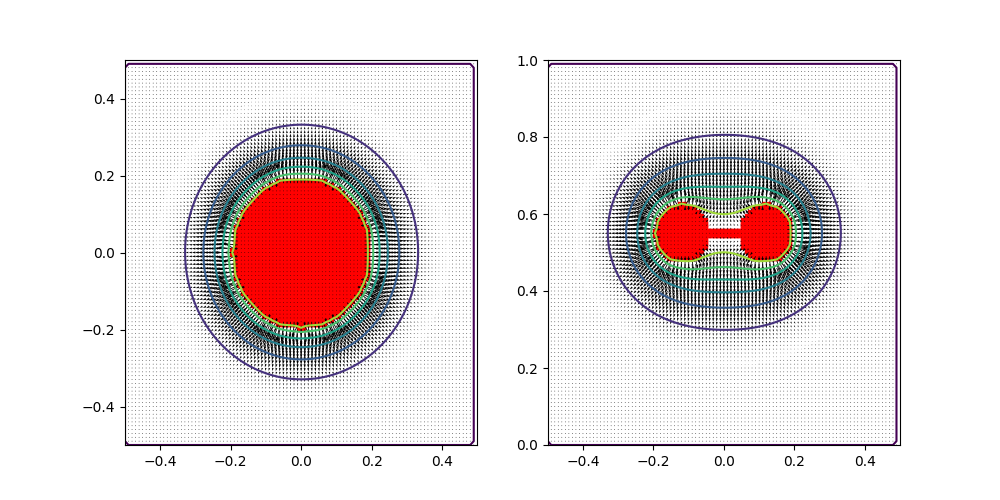

In [103]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

N_middle = np.argmin(np.abs(z_set - zs_f))

fixed_slice = is_fixed[:,:,N_middle]
indices_slice = np.argwhere(fixed_slice == 1)

# https://stackoverflow.com/questions/30216146/numeric-differentiation-of-electric-potential-with-python
# NumPy and MatPlotLib interpret matrix directions differently, hence the transpose... I miss my dear MATLAB <3
U_slice = np.transpose(U[:,:,N_middle])
Ex_slice = np.transpose(Ex[:,:,N_middle])
Ey_slice = np.transpose(Ey[:,:,N_middle])

ax[0].scatter(x_set[indices_slice[:, 0]], y_set[indices_slice[:, 1]], c='r', marker=',')
ax[0].contour(x_set, y_set, U_slice)
ax[0].quiver(x_set, y_set, Ex_slice, Ey_slice)

ax[0].set_xlim([x_min, x_max])
ax[0].set_ylim([y_min, y_max])

L_middle = int(np.round(L/2))
fixed_slice = is_fixed[L_middle,:,:]
indices_slice = np.argwhere(fixed_slice == 1)
U_slice = np.transpose(U[L_middle,:,:])
Ey_slice = np.transpose(Ey[L_middle,:,:])
Ez_slice = np.transpose(Ez[L_middle,:,:])

ax[1].scatter(y_set[indices_slice[:, 0]], z_set[indices_slice[:, 1]], c='r', marker=',')
ax[1].contour(y_set, z_set, U_slice)
ax[1].quiver(y_set, z_set, Ey_slice, Ez_slice)

ax[1].set_xlim([y_min, y_max])
ax[1].set_ylim([z_min, z_max])

## Calculating $C$
Now that we have solved for $\vec{E}$, we wish to find the capacitance associated to the toroidal load. To this end we consider Gauss law for the electric field in the intregral form:
$$
\oiint_A \vec{E}\cdot\mathrm{d}\vec{A} = \frac{1}{\varepsilon_0\varepsilon_r}\iiint_V {\rho \, \mathrm{d}V} = \frac{Q}{\varepsilon_0\varepsilon_r},
$$
where $Q$ is the charge enclosed in the closed surface $A$. Therefore by calculating the flux through any surface containing the toroidal topload, we can compute the charge $Q$ stored in the load. This, together with the definition of capacitance $C = \frac{Q}{V}$ allows us to calculate $C$.

In [104]:
def calculate_flux(normal, Ex_m, Ey_m, Ez_m):
    Ex_v = Ex_m.flatten()
    Ey_v = Ey_m.flatten()
    Ez_v = Ez_m.flatten()
    dim = len(Ez_v)
    
    flux = 0
    
    for i in range(dim):
        E_vector = np.array([Ex_v[i], Ey_v[i], Ez_v[i]])
        flux = flux + np.dot(normal, E_vector)
    return flux

In [105]:
flux = 0

normal = np.array([-1, 0, 0])*h_step**2
Ex_slice = Ex[1,1:M-1,1:N-1]
Ey_slice = Ey[1,1:M-1,1:N-1]
Ez_slice = Ez[1,1:M-1,1:N-1]
flux = flux + calculate_flux(normal, Ex_slice, Ey_slice, Ez_slice)

normal = np.array([+1, 0, 0])*h_step**2
Ex_slice = Ex[L-2,1:M-1,1:N-1]
Ey_slice = Ey[L-2,1:M-1,1:N-1]
Ez_slice = Ez[L-2,1:M-1,1:N-1]
flux = flux + calculate_flux(normal, Ex_slice, Ey_slice, Ez_slice)

normal = np.array([0, -1, 0])*h_step**2
Ex_slice = Ex[1:L-1,1,1:N-1]
Ey_slice = Ey[1:L-1,1,1:N-1]
Ez_slice = Ez[1:L-1,1,1:N-1]
flux = flux + calculate_flux(normal, Ex_slice, Ey_slice, Ez_slice)

normal = np.array([0, +1, 0])*h_step**2
Ex_slice = Ex[1:L-1,M-2,1:N-1]
Ey_slice = Ey[1:L-1,M-2,1:N-1]
Ez_slice = Ez[1:L-1,M-2,1:N-1]
flux = flux + calculate_flux(normal, Ex_slice, Ey_slice, Ez_slice)

normal = np.array([0, 0, -1])*h_step**2
Ex_slice = Ex[1:L-1,1:M-1,1]
Ey_slice = Ey[1:L-1,1:M-1,1]
Ez_slice = Ez[1:L-1,1:M-1,1]
flux = flux + calculate_flux(normal, Ex_slice, Ey_slice, Ez_slice)

normal = np.array([0, 0, +1])*h_step**2
Ex_slice = Ex[1:L-1,1:M-1,N-2]
Ey_slice = Ey[1:L-1,1:M-1,N-2]
Ez_slice = Ez[1:L-1,1:M-1,N-2]
flux = flux + calculate_flux(normal, Ex_slice, Ey_slice, Ez_slice)

epsilon_0 = 8.8541878128e-12
Q = flux*epsilon_0

Cs_num = Q
Cs_num


2.9414932344717726e-12

## Primary Capacitance
We now calculate the optimum primary capacitance for DRSSTC operation (dual-resonance). To thie end we consider the LC resonant frequency
$$
f = \frac{1}{2\pi\sqrt{L C}}.
$$

In [106]:
fs_res = 1/(2*np.pi*np.sqrt(Ls_num * Cs_num))
fs_res

292008.58142068866

Setting the resonant frequencies of the primary and secondary to be the same, we get that
$$
C_p = \frac{L_s}{L_p} C_s 
$$

In [107]:
Cp_num = Ls_num/Lp_num*Cs_num
Cp_num

8.975925245267007e-09

## Calculating Transfer Function
In this section, given the lumped model parameters calculated above, we compute the transfer function of the entire system.

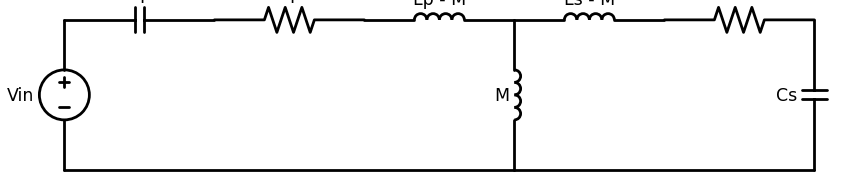

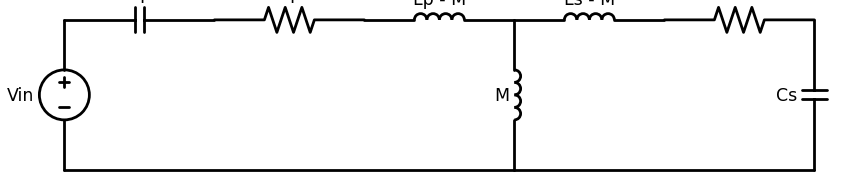

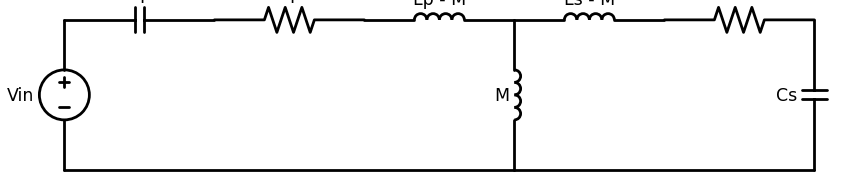

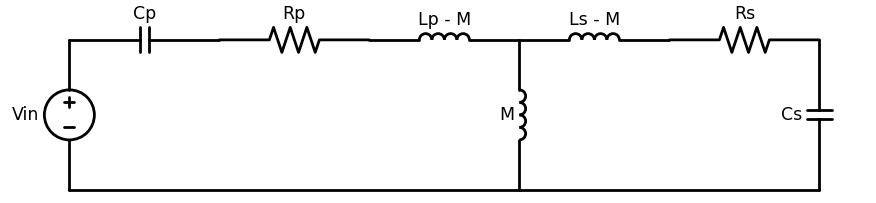

In [112]:
d = schemdraw.Drawing()
C = d.add(elm.Capacitor(label="Cp"))
d.add(elm.Resistor(label="Rp"))
L = d.add(elm.Inductor(label="Lp - M"))
M = d.add(elm.Inductor("down", label="M"))
d.add(elm.Line('left', tox=C.start))
d.add(elm.SourceV('up', label="Vin"))
d.add(elm.Inductor("right", label="Ls - M", at=L.end))
d.add(elm.Resistor(label="Rs"))
d.add(elm.Capacitor("down", label="Cs"))
d.add(elm.Line("left", tox=M.end))
d.draw()

In [113]:
i1, i2, i3 = symbols("i1 i2 i3")
vin, vout = symbols("vin vout")

Rp, Cp, Lp = symbols("Rp, Cp, Lp")
Rs, Cs, Ls = symbols("Rs, Cs, Ls")

k, M = symbols("k M")
s = symbols("s")

Zp = 1/(s*Cp) + Rp + s*(Lp - M)
Zs = 1/(s*Cs) + Rs + s*(Ls - M)
Zm = s*M

eq1 = vin - Zp*i1 - Zm*i2
eq2 = Zm*i2 - i3*Zs
eq3 = i1 - i2 - i3

res = solve([eq1, eq2, eq3], [i1, i2, i3])
i3_sol = res[i3]

vout = i3_sol/(s*Cs)
Tf = vout/vin

Tf = Tf.subs(M, k*sqrt(Lp*Ls))
Tf

Cp*k*s**2*sqrt(Lp*Ls)/(-Cp*Cs*Lp*Ls*k**2*s**4 + Cp*Cs*Lp*Ls*s**4 + Cp*Cs*Lp*Rs*s**3 + Cp*Cs*Ls*Rp*s**3 + Cp*Cs*Rp*Rs*s**2 + Cp*Lp*s**2 + Cp*Rp*s + Cs*Ls*s**2 + Cs*Rs*s + 1)

In [114]:
numerical_expressions = {
    # Circuit lumped parameters
    # Primary winding
    Rp : Rp_num,      # [Ohm]
    Lp : Lp_num,   # [H]
    Cp : Cp_num,   # [F]
    # Secondary winding
    Rs : Rs_num,      # [Ohm]
    Ls : Ls_num, # [H]
    Cs : Cs_num,  # [F]
    # Coupling coefficient
    k : k_num,     # [1]  
}

Tf_sim = Tf.subs(numerical_expressions)
Tf_sim

4.99821586131924e-12*s**2/(8.00597335286754e-26*s**4 + 1.24867514828194e-22*s**3 + 5.94126676196256e-13*s**2 + 4.20339723264412e-10*s + 1)

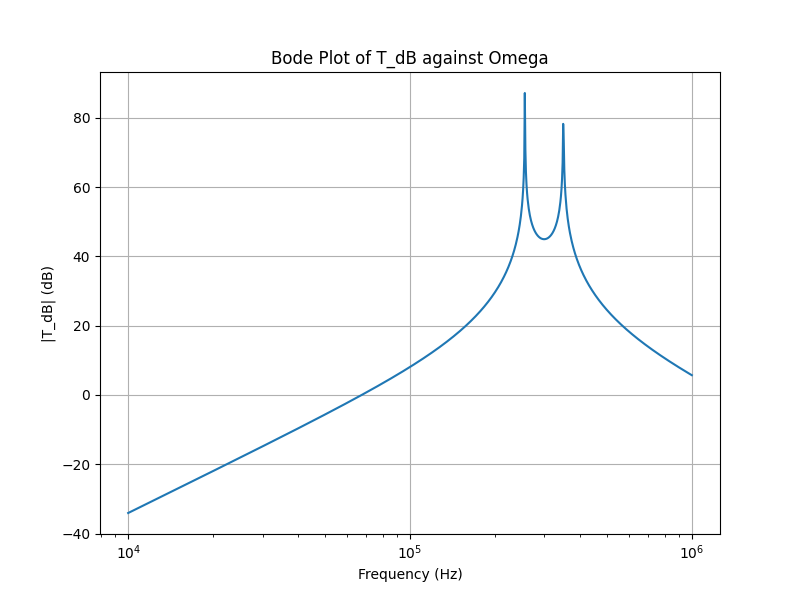

In [115]:
freq = np.logspace(4, 6, 1000)  # [Hz]
omega = 2*np.pi*freq            # [rad/s]
s_num = 1j*omega

Tf_lambda = lambdify(s, Tf_sim, 'numpy')

Tf_eval = np.array([Tf_lambda(s_) for s_ in s_num])
Tf_db = 20 * np.log10(np.abs(Tf_eval))
 
plt.figure(figsize=(8, 6))

plt.semilogx(freq, Tf_db)

plt.title('Bode Plot of T_dB against Omega')
plt.xlabel('Frequency (Hz)')
plt.ylabel('|T_dB| (dB)')
plt.grid(True)
plt.show()

In [116]:
client.create_notification(
        title="All Done",
        subtitle="The code has finished running"
    )